In [1]:
from __future__ import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%pylab notebook
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
lib_path = '/home/fgeigl/navigability_of_networks'
print('append', lib_path)
sys.path.append(lib_path)
import network_matrix_tools
import powerlaw
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

Populating the interactive namespace from numpy and matplotlib
append /home/fgeigl/
append /home/fgeigl/navigability_of_networks


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def find_files(base_dir, file_ending):
    res = list()
    for root, dirs, files in os.walk(base_dir):
        if not root.endswith('/'):
            root += '/'
        res.extend([root + i for i in filter(lambda x: x.endswith(file_ending), files)])
    return sorted(res)

base_dir = '/home/fgeigl/navigability_of_networks/output/opt_link_man/'
net_files = filter(lambda x: 'bow_tie' not in x, find_files(base_dir,'.gt'))
print('Networks:', net_files)
debug = False
plots_dir = base_dir + 'network_property_plots/'
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

Networks: ['/home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt', '/home/fgeigl/navigability_of_networks/output/opt_link_man/tvthek_orf.gt/tvthek_orf.gt', '/home/fgeigl/navigability_of_networks/output/opt_link_man/wiki4schools.gt/wiki4schools.gt']


In [3]:
networks = dict()
ds_name_conv = {'daserste.gt':'DEM', 'tvthek_orf.gt':'ORF', 'wiki4schools.gt':'W4S'}
for i in net_files:
    print('\tload:', i.rsplit('/', 1)[-1])
    networks[ds_name_conv[i.rsplit('/',1)[-1]]] = load_graph(i)
print(networks)
    

	load: daserste.gt
	load: tvthek_orf.gt
	load: wiki4schools.gt
{'ORF': <Graph object, directed, with 9799 vertices and 301844 edges at 0x7fc4c1feb390>, 'W4S': <Graph object, directed, with 4051 vertices and 111795 edges at 0x7fc462ec26d0>, 'DEM': <Graph object, directed, with 70063 vertices and 3448513 edges at 0x7fc4c005a7d0>}


<IPython.core.display.Javascript object>


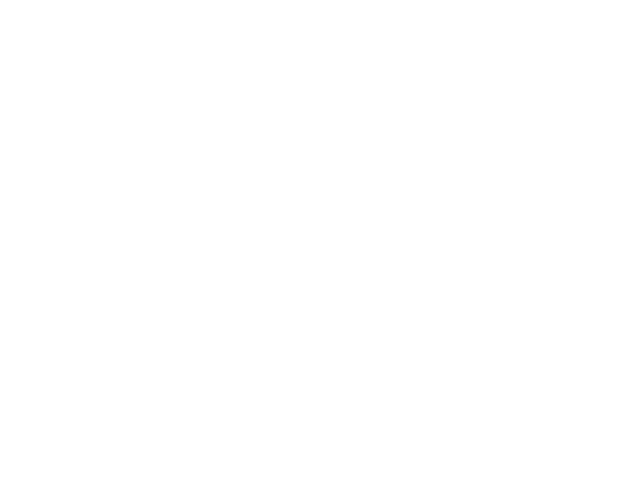

<IPython.core.display.Javascript object>


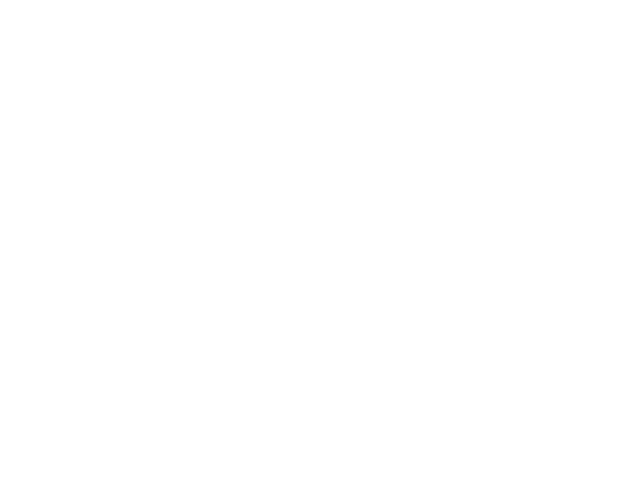

<IPython.core.display.Javascript object>


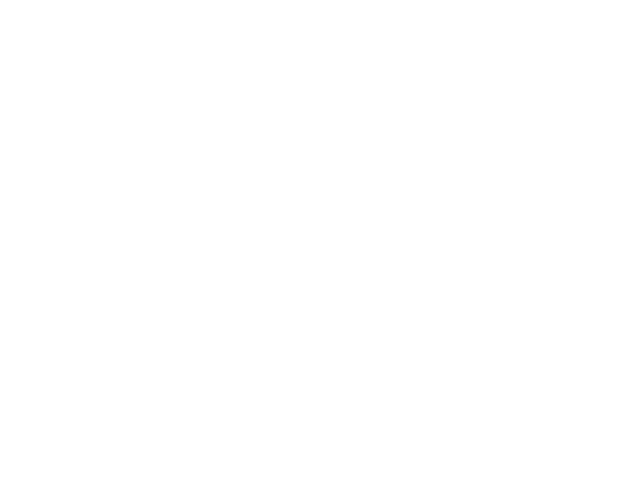

In [4]:
# plt.style.use('ggplot')
for ds, net in networks.iteritems():
    num_v, num_e = net.num_vertices(), net.num_edges()
    density = num_e/(num_v*(num_v-1))
    avg_deg = num_e/num_v
    phis = np.array([0.01, 0.1, 0.2])
    df_dens = pd.DataFrame(index=phis)
    df_rel_dens = pd.DataFrame(index=phis)
    for phi in phis:
        num_ins_edges = phi * num_v * avg_deg
        for b in [2, 5, 15, 50, 100, 150, 200]:
            df_dens.at[phi, b] = (num_e + (num_ins_edges*(b-1)))/(num_v*(num_v-1))
            df_rel_dens.at[phi, b] = df_dens.at[phi, b] / density
    # df_rel_dens.plot(legend=False) identical values
    df_dens.plot(legend=False, marker='*')
    plt.xlabel(r'$\phi$')
    plt.ylabel('density')
    plt.title(ds)
    plt.grid()
    plt.tight_layout()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


<IPython.core.display.Javascript object>


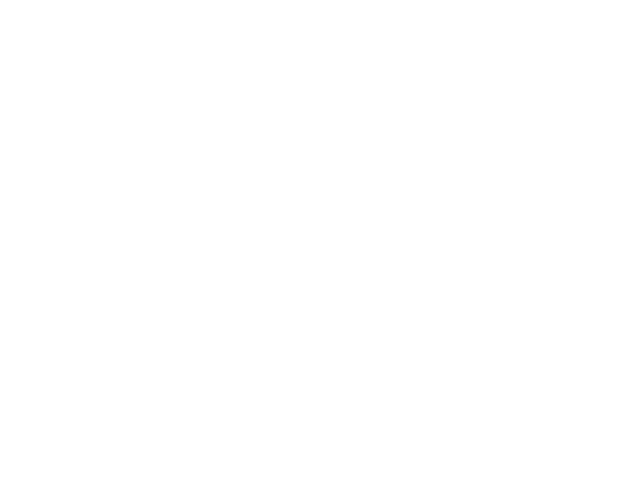

<IPython.core.display.Javascript object>


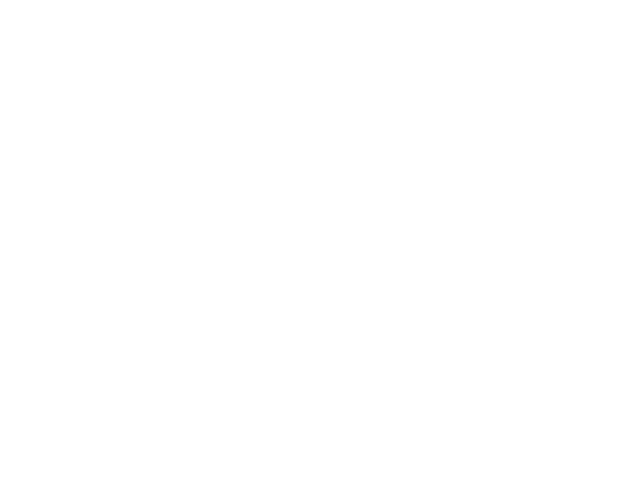

<IPython.core.display.Javascript object>


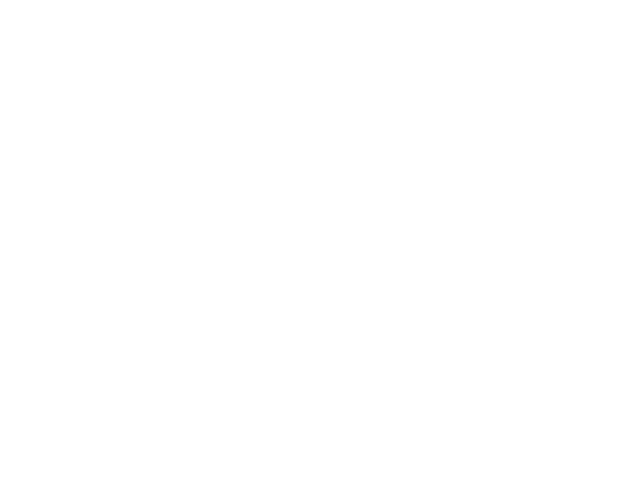

<IPython.core.display.Javascript object>


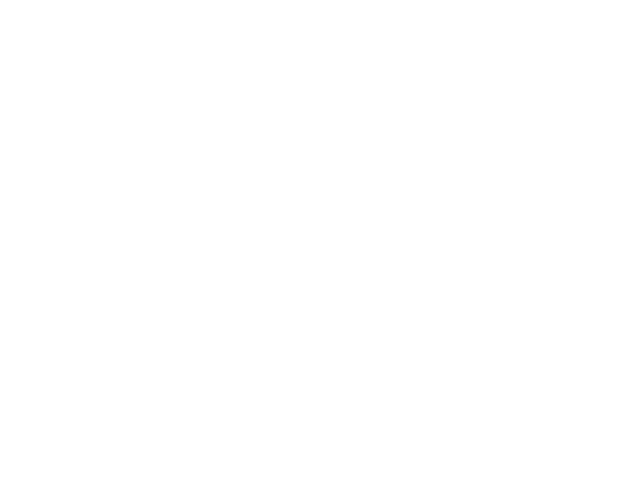

In [5]:
df = pd.DataFrame()
for ds, net in networks.iteritems():
    df.at['density', ds] = net.num_edges()/(net.num_vertices()*(net.num_vertices()-1))
    df.at['powerl. alpha total', ds] = powerlaw.Fit(net.degree_property_map('total').a, discrete=True).power_law.alpha
    df.at['powerl. alpha out', ds] = powerlaw.Fit(net.degree_property_map('out').a, discrete=True).power_law.alpha
    df.at['powerl. alpha in', ds] = powerlaw.Fit(net.degree_property_map('in').a, discrete=True).power_law.alpha
    # df.at['clust.coef.', ds] = global_clustering(net)[0]

for jdx,idx in enumerate(df.index):
    fig, ax = plt.subplots()
    df.loc[idx].plot.bar(ax=ax, legend=False)
    plt.title(idx)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


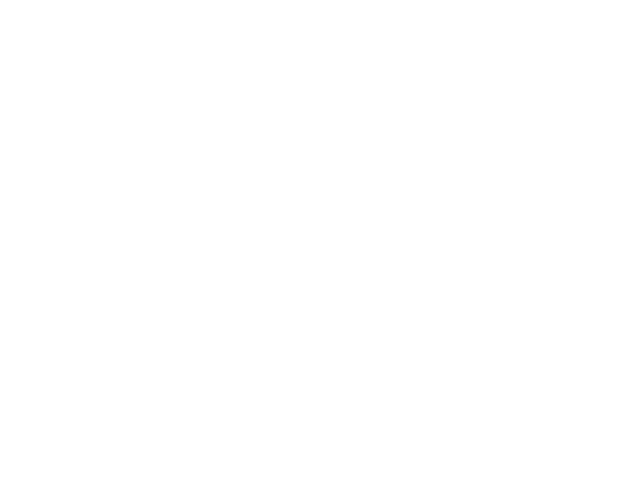

in


<IPython.core.display.Javascript object>


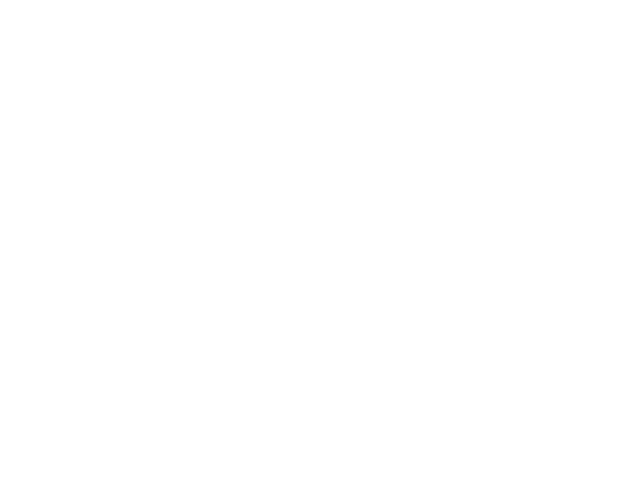

out


<IPython.core.display.Javascript object>


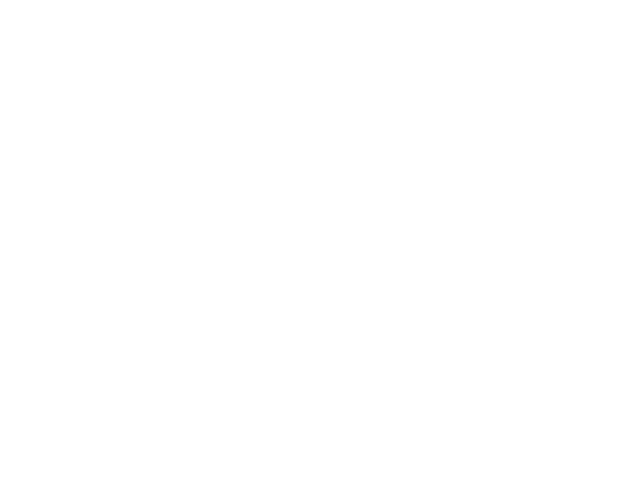

total


In [6]:
colors = ['#e41a1c','#377eb8','#4daf4a']
for d_type in ['in', 'out', 'total']:
    fig, ax = plt.subplots()
    print(d_type)
    for idx, (ds, net) in enumerate(networks.iteritems()):
        counts, bins = vertex_hist(net, d_type)
        ax.plot(bins[:-1], counts, label=ds, lw=2, c=colors[idx])
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    plt.close('all')

In [7]:
phi_vals = np.arange(0.05,1.01, 0.05)
df = pd.DataFrame(index=phi_vals)

for ds, net in sorted(networks.iteritems(), key=lambda x:x[1].num_vertices()):
    _, stat_dist = network_matrix_tools.calc_entropy_and_stat_dist(adjacency(net), method='EV',
                                                                            smooth_bias=False,
                                                                            calc_entropy_rate=False, verbose=False)
    stat_dist.sort()
    for phi in phi_vals:
        df.at[phi, ds] = stat_dist[-int(np.round(len(stat_dist)*phi)):].sum()
df.head()  

,W4S,ORF,DEM
0.05,0.407530,0.870570,0.997329
0.10,0.562962,0.925781,0.998954
0.15,0.667314,0.953148,0.999742
0.20,0.742766,0.969115,0.999944
0.25,0.800626,0.981121,0.999972


<IPython.core.display.Javascript object>


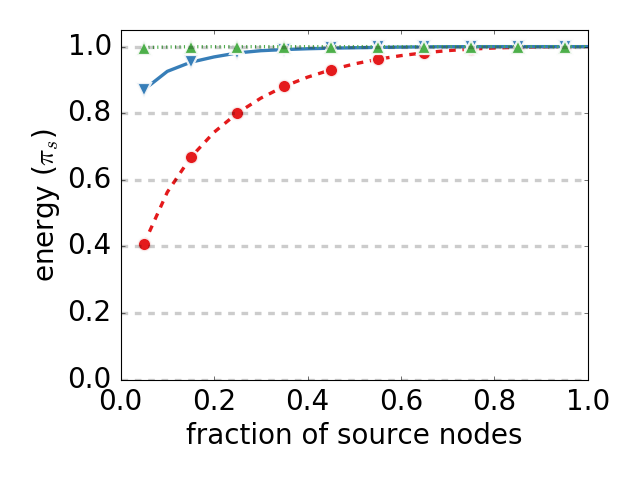

In [8]:
colors = ['#e41a1c','#377eb8','#4daf4a']
markers = "ov^<>sp*+x"
line_styles = ['--', '-', ':']
matplotlib.rcParams.update({'font.size': 25})
ax = None
for c_idx, c in enumerate(df.columns):
    color = colors[c_idx]
    marker = markers[c_idx]
    ls = line_styles[c_idx]
    ax = df[c].plot(color=color, ax=ax, label=c if jdx == 1 else None, lw=3,
                    marker=marker, ms=12, ls=ls, markeredgewidth = 2, markeredgecolor = (.99, .99, .99, .9), markevery=2)
plt.ylim([0.,1.05])
plt.xlim(0, 1)
plt.ylabel(r"energy ($\pi_s$)")
plt.xlabel(r'fraction of source nodes')
# plt.legend(loc='lower right')
ax.grid(b=True, which='major', axis='y', linewidth=3, alpha=0.2, ls='--')
plt.tight_layout()
plt.show()
plt_tools.save_n_crop(plots_dir + 'lorenz_curve.pdf')
# plt_tools.plot_legend(ax,plots_dir + 'stat_dist_rel_'+ method + '_legend.pdf', close_plot=False)

In [9]:
mdf = pd.read_pickle(base_dir + 'avg_measures.df')
mdf.head()

,com_in_deg,com_out_deg,ratio_com_out_deg_in_deg,orig_stat_dist_sum
daserste,"[{0.2: 565424.34, 0.1: 318892.52, 0.01: 33735....","[{0.2: 568176.83, 0.1: 313909.21, 0.01: 34215....","[{0.2: 1.13298359627, 0.1: 1.24114295947, 0.01...",[None]
tvthek_orf,"[{0.2: 49061.73, 0.1: 26463.6060606, 0.01: 253...","[{0.2: 49361.67, 0.1: 27533.3333333, 0.01: 300...","[{0.2: 1.08395797277, 0.1: 1.15349397034, 0.01...",[None]
wiki4schools,"[{0.2: 17982.32, 0.1: 10021.66, 0.01: 1061.19}]","[{0.2: 17838.01, 0.1: 9998.03, 0.01: 1106.42}]","[{0.2: 0.997066750425, 0.1: 1.00689184446, 0.0...",[None]


In [10]:
tmp_storeage = dict()
for measure in ['ratio_com_out_deg_in_deg', 'com_out_deg', 'com_in_deg']:
    plot_df = pd.DataFrame()
    for idx, val in mdf[[measure]].iterrows():
        index, values = zip(*sorted(val.values[0][0].iteritems(), key=lambda x:x[0]))
        # print(index, values)
        ser = pd.Series(values, index=index)
        plot_df[ds_name_conv[idx+'.gt']] = ser
    tmp_storeage[measure] = plot_df
    if measure != 'ratio_com_out_deg_in_deg' or True:
        plot_df = plot_df.apply(lambda x: x / x.min(), axis=1)
    print(plot_df)
    plot_df = plot_df[list(reversed(plot_df.columns))]
    ax = plot_df.plot(lw=3, kind='bar', color=['#e41a1c','#377eb8','#4daf4a'], rot=0, legend=False)
    ax.set_ylabel(r'$\varnothing$ degree ratio ($\overline{d^r_t}$)')
    if measure == 'ratio_com_out_deg_in_deg':
        ax.set_xlabel('fraction of target nodes ($\phi$)')
    else:
        ax.set_ylabel(measure)
    ax.grid(b=True, which='major', axis='y', linewidth=3, alpha=0.2, ls='--')
    plt.tight_layout()
    plt_tools.save_n_crop(plots_dir + 'avg_' + measure + ".pdf")

           DEM       ORF  W4S
0.01  4.579861  1.549371    1
0.10  1.232648  1.145599    1
0.20  1.136317  1.087147    1


<IPython.core.display.Javascript object>

            DEM       ORF  W4S
0.01  30.924414  2.716798    1
0.10  31.397106  2.753876    1
0.20  31.852030  2.767218    1


<IPython.core.display.Javascript object>

            DEM       ORF  W4S
0.01  31.790396  2.387352    1
0.10  31.820329  2.640641    1
0.20  31.443348  2.728331    1


<IPython.core.display.Javascript object>

In [11]:
tmp_storeage

{'com_in_deg':             DEM           ORF       W4S
 0.01   33735.65   2533.434343   1061.19
 0.10  318892.52  26463.606061  10021.66
 0.20  565424.34  49061.730000  17982.32,
 'com_out_deg':             DEM           ORF       W4S
 0.01   34215.39   3005.919192   1106.42
 0.10  313909.21  27533.333333   9998.03
 0.20  568176.83  49361.670000  17838.01,
 'ratio_com_out_deg_in_deg':            DEM       ORF       W4S
 0.01  5.109714  1.728621  1.115692
 0.10  1.241143  1.153494  1.006892
 0.20  1.132984  1.083958  0.997067}

In [12]:
in_deg = tmp_storeage['com_in_deg']
out_deg = tmp_storeage['com_out_deg']
out_deg / in_deg


,DEM,ORF,W4S
0.01,1.014221,1.186500,1.042622
0.10,0.984373,1.040423,0.997642
0.20,1.004868,1.006114,0.991975


In [13]:
exit()